In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from sklearn.decomposition import PCA
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## 0. Read samples location info

In [2]:
def read_samples_info(dir_path, file_name):
    file_data = glob(dir_path + file_name)[0]
    INFO = pd.read_csv(file_data, sep='\t')[['Sample_ID', 'country', 'year', 'post_dupe_depth', 'RMU']]
    INFO.rename(columns={'Sample_ID':'sample', 
                         'country':'country',
                         'RMU': 'RMU',
                         'year':'year', 
                         'post_dupe_depth':'depth'}, inplace=True)
    return INFO

In [3]:
countries_order = ['Indonesia', 'Solomon_Islands', 'Malaysia', 'Papua_New_Guinea', 'Mexico', 'Virgin_Islands',
                   'French_Guiana', 'Suriname', 'Costa_Rica', 'Ghana', 'Gabon', 'South_Africa', 
                   'Florida', 'Peru', 'USA', 'Chile']

In [4]:
country_palette_dict = {
    'Mexico': '#1f77b4',
    'Virgin_Islands': '#ff7f0e',
    'Solomon_Islands': '#2ca02c',
    'South_Africa': '#d62728',
    'Suriname': '#9467bd',
    'French_Guiana': '#8c564b',
    'Malaysia': '#e377c2',
    'Papua_New_Guinea': '#7f7f7f',
    'Indonesia': '#bcbd22',
    'Costa_Rica': '#17becf',
    'Ghana': '#ff1493',
    'Gabon': '#ffab40',
    'Florida': '#7570b3',
    'USA': '#e7298a',
    'Peru': '#66a61e',
    'Chile': '#d95f02'}

## 1. PCA analysis

### 1.1. Read PCA eigenvectors and eigenvalues

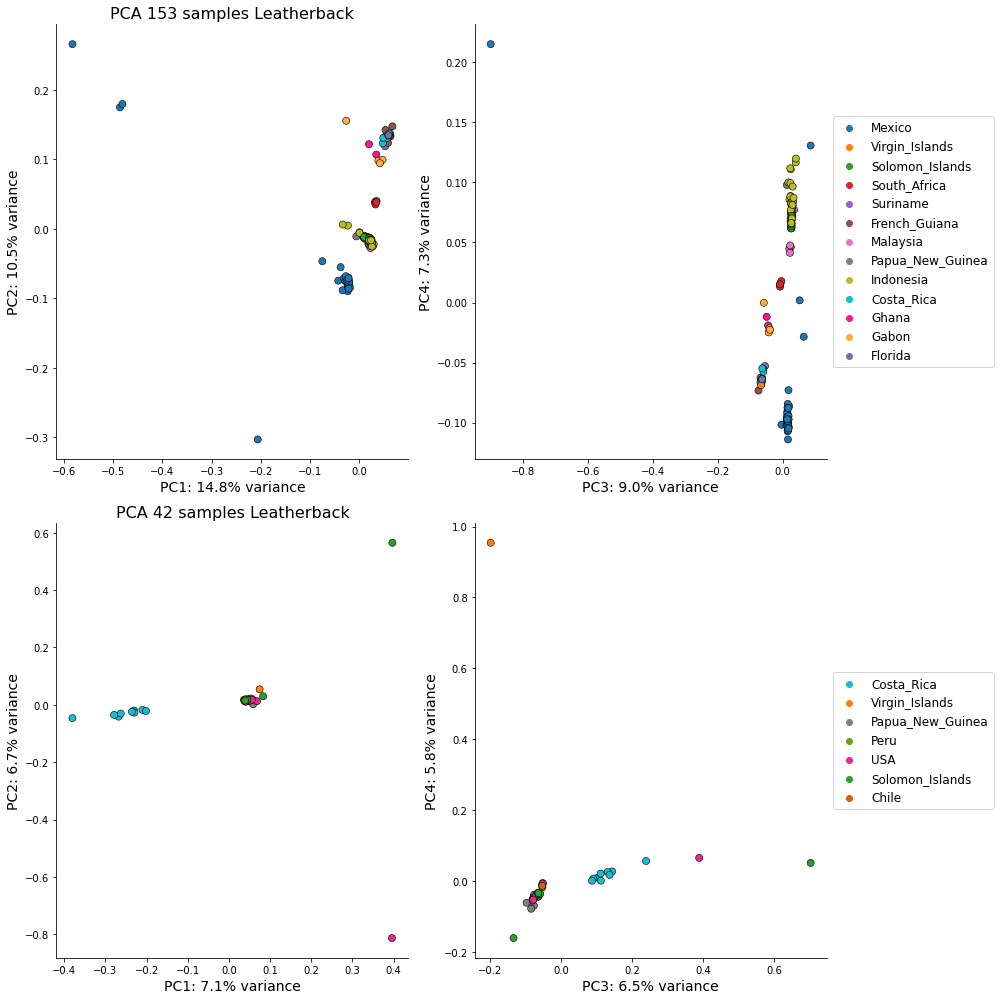

In [12]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'

# Create a consistent color palette
# country_palette = sns.color_palette("bright", len(countries_order))
# country_palette_dict = dict(zip(countries_order, country_palette))

color_by = 'country'
# color_by = 'RMU'

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

for i, derCor in enumerate(['153', '42']):
    ## Read location info
    file_name_info = f'dc_{derCor}_samples_info.tsv'
    INFO = read_samples_info(dir_path, file_name_info)
    
    ## Read eigenvectors
    file_name_eigenvec = f'PCA/pca.ld_pruned_0.2.derCor_{derCor}.eigenvec'
    file_data = glob(dir_path + file_name_eigenvec)[0]
    df = pd.read_csv(file_data, sep=' ', header=None)

    ## Assign column names
    df = df.iloc[:, 1:]
    num_pcs = df.shape[1]
    column_names = ['sample'] + [f'PC{i}' for i in range(1, num_pcs)]
    df.columns = column_names

    ## Assign location to each sample
    df_all = pd.merge(df, INFO, on='sample')

    ## Read eigenvalues
    file_name_eigenval = f'PCA/pca.ld_pruned_0.2.derCor_{derCor}.eigenval'
    eigenval = [float(l.strip()) for l in open(dir_path + file_name_eigenval, 'r')]
    variance = [l / sum(eigenval) * 100 for l in eigenval]

    for j in range(2):
        ## Plot PCx vs PCy
        ax = axes[i][j]
        sns.scatterplot(ax=ax, data=df_all, x=f'PC{2*j+1}', y=f'PC{2*j+2}', hue=color_by, s=50, edgecolor='k', 
                        palette=country_palette_dict)


        ax.set_xlabel(f'PC{2*j+1}: {variance[2*j]:.1f}% variance', fontsize=14)
        ax.set_ylabel(f'PC{2*j+2}: {variance[2*j+1]:.1f}% variance', fontsize=14)
        
        if j > 0:
            ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
        else:
            ax.set_title(f"PCA {derCor} samples Leatherback", fontsize=16)
            ax.get_legend().remove()

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [14]:
df_all[df_all['PC1'] > 0.3]

,sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,country,year,depth,RMU
26,Z061468,0.396886,0.565218,0.701981,0.051127,-0.007869,0.033823,-0.002026,-0.004099,0.004081,...,-0.004054,0.005326,-0.008744,0.013234,0.006358,-0.001076,Solomon_Islands,2006.0,NaN,Western Pacific
30,Z178011,0.395800,-0.813229,0.388386,0.065468,-0.017841,0.025776,-0.011282,-0.006529,-0.013237,...,-0.003508,-0.001183,0.003346,0.008853,0.001781,-0.001233,USA,2016.0,NaN,Western Pacific


## 2. Admixture analysis

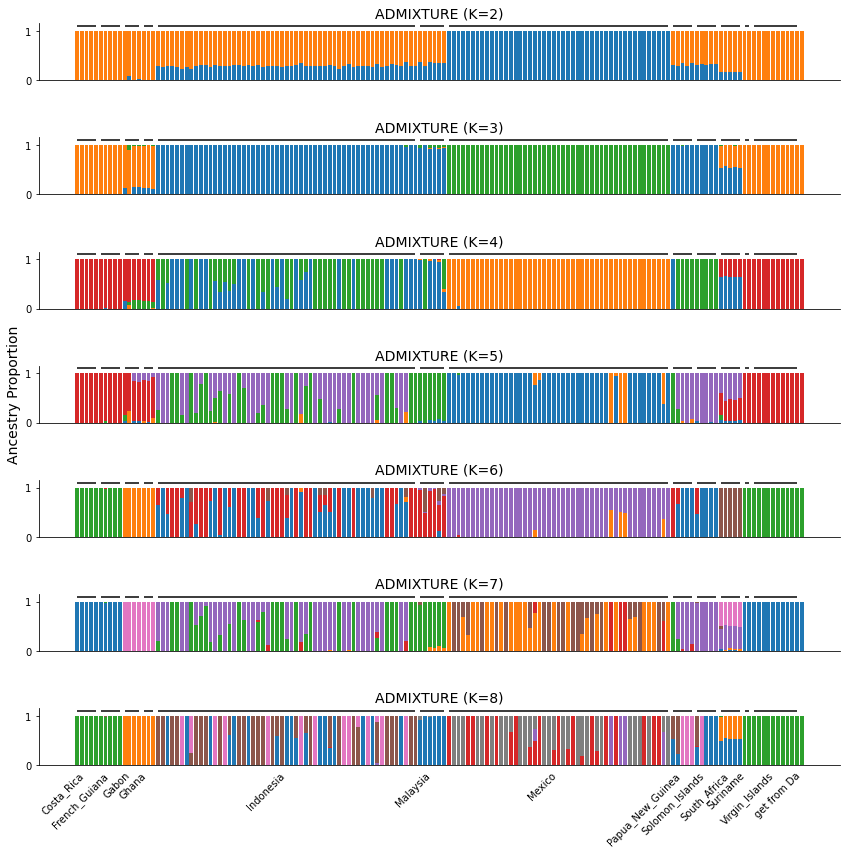

In [98]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
out_dir = "admixture_out/"
k_values = range(2, 9)

fig, axes = plt.subplots(len(k_values), 1, figsize=(12, 12))

for i in range(len(k_values)):
    k = k_values[i]
    
    # Load Q matrix
    file_name = "named.turtles_ld_pruned.{}.Q".format(k)
    file_data = glob(dir_path + out_dir + file_name)[0]
    q_matrix = pd.read_csv(file_data, sep="\t", names=['sample'] + list(range(1, k+1)), index_col=False)
    df_q = pd.merge(q_matrix, INFO, on='sample')
    df_q.sort_values('country', inplace=True,ignore_index=True)
    ax = axes[i]
    
    # Stacked bar plot for each individual
    bottom = pd.Series(0, index=df_q.index)
    for cluster in range(1, k+1):
        ax.bar(df_q.index, 
               df_q[cluster], 
               bottom=bottom)
        bottom += df_q[cluster]
    
    ax.set_title(f"ADMIXTURE (K={k})", fontsize=14)
    if i == 3:
        ax.set_ylabel("Ancestry Proportion", fontsize=14)
    ax.set_xticks([])


    # Calculate midpoints for country labels
    countries = df_q['country'].unique()
    positions = []
    labels = []
    line_ranges = []

    for country in countries:
        subset = df_q[df_q['country'] == country]
        midpoint = (subset.index[0] + subset.index[-1]) / 2
        positions.append(midpoint)
        labels.append(country)
        line_ranges.append((subset.index[0], subset.index[-1]))

    # Add horizontal lines above the plot
    line_y = 1.1
    for start, end in line_ranges:
        ax.hlines(y=line_y, xmin=start, xmax=end, color='black', linewidth=1.5)

    # Add country labels
    if i == len(k_values) - 1:
        for pos, label in zip(positions, labels):
            ax.text(pos, -0.1, label, ha='right', va='top', rotation=45)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()